In [2]:
import numpy as np
import pandas as pd
# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
import yfinance as yf

DX = yf.Ticker("DX-Y.NYB")
raw_data = DX.history(period = 'max')['Close']
raw_data.tail()

Date
2021-08-31    92.629997
2021-09-01    92.449997
2021-09-02    92.230003
2021-09-03    92.040001
2021-09-06    92.251999
Name: Close, dtype: float64

<AxesSubplot:xlabel='Date'>

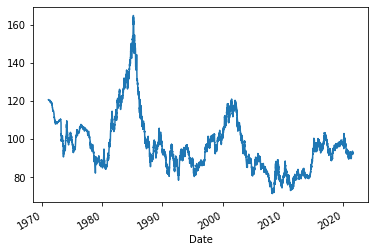

In [4]:
raw_data.plot()

In [48]:
def log_return(series):
    return np.log(series).diff()


In [53]:
raw_data = log_return(raw_data)[1::]

In [74]:
raw_data.min()

-0.05129333963229321

用create_seq將一個時間序列依想要訓練的長度  
拆成訓練資料與target  

In [5]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length ):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [54]:
create_sequences(raw_data.loc['2021'::], 5)
#將每5天抓出來成為一個array 並用第6天的當成收盤價

(array([[-0.00066739, -0.00490738,  0.00100571,  0.00334526,  0.00300113],
        [-0.00490738,  0.00100571,  0.00334526,  0.00300113,  0.0048716 ],
        [ 0.00100571,  0.00334526,  0.00300113,  0.0048716 , -0.00542665],
        [ 0.00334526,  0.00300113,  0.0048716 , -0.00542665,  0.00299381],
        [ 0.00300113,  0.0048716 , -0.00542665,  0.00299381, -0.00088615],
        [ 0.0048716 , -0.00542665,  0.00299381, -0.00088615,  0.00596622],
        [-0.00542665,  0.00299381, -0.00088615,  0.00596622, -0.00308913],
        [ 0.00299381, -0.00088615,  0.00596622, -0.00308913, -0.00033153],
        [-0.00088615,  0.00596622, -0.00308913, -0.00033153, -0.00376528],
        [ 0.00596622, -0.00308913, -0.00033153, -0.00376528,  0.00121972],
        [-0.00308913, -0.00033153, -0.00376528,  0.00121972,  0.00166087],
        [-0.00033153, -0.00376528,  0.00121972,  0.00166087, -0.00243688],
        [-0.00376528,  0.00121972,  0.00166087, -0.00243688,  0.0053092 ],
        [ 0.00121972,  0.

In [55]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [75]:
class DX_dataset(Dataset):
    def __init__(self, data, mode = 'train'):
         
        #set data split
        test_date = '2021'
        start_train = '2010'
        end_train='2020'    
        self.seq_length = config['seq_length']

        self.mode = mode
        
        if self.mode == 'test': #就是test mode的情況下
            x,y = create_sequences(data.loc[test_date], self.seq_length)
            self.data = torch.FloatTensor(x)
            self.test_target = y # 用來評斷test的loss
        else: 
            # create sequence 
            x,y = create_sequences(data.loc[start_train:end_train], self.seq_length)
            
            sub_train_size = round(len(x)*0.8) #train_mode set 80% for training
            if self.mode == 'train':
                self.data = torch.FloatTensor(x[0:sub_train_size])
                self.target = torch.FloatTensor(y[0:sub_train_size])
            elif self.mode == 'vaildation':
                self.data = torch.FloatTensor(x[sub_train_size::])
                self.target = torch.FloatTensor(y[sub_train_size::])
            
            #self.target = \
            #(self.target - self.target.mean(dim=0, keepdim=True)) \
            #/ self.target.std(dim=0, keepdim=True)
        
        self.data = \
            (self.data - self.data.mean(dim=0, keepdim=True)) \
            / self.data.std(dim=0, keepdim=True)
        #取log diff 後 應該就不用在做標準化了
        

    def __getitem__(self, index):
        
        if self.mode in ['train', 'vaildation']:
            # For training
            return self.data[index].view(1,self.seq_length), self.target[index]
        else:
            # For testing (no target)
            return self.data[index].view(1,self.seq_length)
            
    def __len__(self): 
        # Returns the size of the dataset
        return len(self.data)

In [76]:
def prep_dataloader(data, mode, batch_size, n_jobs=0):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = DX_dataset(data, mode=mode)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=True,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [77]:
#optimizer 用Adam
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 64,               # mini-batch size for dataloader
    'seq_length' : 14,
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        #'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200             # early stopping epochs (the number epochs since your model's last improvement) # your model will be saved here
}


In [78]:
data = prep_dataloader(raw_data, mode= 'train',batch_size = 3)

In [79]:
for x,y in data:
    print(f'train_data: {x}, target : {y}')
    print(f'train_data_shape : {x.shape}')

train_data: tensor([[[ 0.8678,  0.4453, -0.4865, -1.1429, -2.0932, -1.3986,  0.3359,
          -0.1165,  0.1456, -0.4260, -0.6890, -2.2078,  0.4152, -0.7936]],

        [[-0.9338,  1.1019,  0.7589, -0.5663,  0.0319, -0.7245,  0.8645,
           0.0047,  0.8351, -0.5916, -0.6967,  0.5263, -0.5927, -0.1243]],

        [[-0.1555, -0.9178, -0.8943,  0.0612, -1.7504,  0.9698, -1.9528,
          -1.0213, -0.0209, -0.2162,  0.3139, -0.2429, -0.8299, -1.1988]]]), target : tensor([ 0.0027, -0.0022,  0.0051])
train_data_shape : torch.Size([3, 1, 14])
train_data: tensor([[[ 0.6116,  3.0537,  3.0380, -0.7185, -0.9730,  0.6523,  0.1186,
          -0.8348,  3.4906, -0.8244, -1.9725,  1.7099,  0.8687,  0.7542]],

        [[-0.8847, -0.9417,  0.0848,  0.4268, -1.0225,  2.3200, -1.1497,
          -0.1003, -0.7588, -0.8412, -0.7641,  0.2989,  0.5116,  1.0384]],

        [[-0.0199, -0.1804, -1.1695,  0.7813, -0.3943, -1.4703,  1.5356,
          -0.3693, -0.0209,  0.4068, -0.3951, -0.3687, -1.3399,  1.112

train_data: tensor([[[-0.1797, -1.1694,  0.7815, -0.3948, -1.4691,  1.5355, -0.3694,
          -0.0213,  0.4072, -0.3958, -0.3690, -1.3392,  1.1125, -1.3683]],

        [[ 0.6070, -0.5579, -0.3347,  1.0094, -0.3780, -0.8286,  0.6073,
          -1.4836,  0.0693, -0.4277, -1.1767,  0.0481, -0.2017, -1.9178]],

        [[ 0.2195, -0.1003, -1.8370,  0.3812, -0.1809, -0.3966, -0.1558,
          -0.7484, -0.6691,  0.3301,  1.2996,  0.4091, -0.2612, -0.7463]]]), target : tensor([-0.0014,  0.0047, -0.0021])
train_data_shape : torch.Size([3, 1, 14])
train_data: tensor([[[ 0.1951, -0.2595,  0.3376, -0.1641,  0.7429, -0.8559, -0.6681,
          -0.6218, -0.0690,  0.4112,  0.0997, -0.9101,  0.1974,  0.2209]],

        [[-0.1276, -0.1553, -0.1825, -0.1018, -0.2633,  0.3302, -0.8871,
           0.0871, -0.0480, -0.1026, -0.9715,  0.1977,  0.5515,  1.2527]],

        [[-0.9257,  0.1129, -0.2877,  0.1127,  2.1325,  1.0609,  1.2388,
           0.2664,  0.3707,  0.9417, -0.1243,  0.6548, -0.5131,  1.431

train_data: tensor([[[-1.3421, -0.3034, -3.4885, -1.8429,  1.2262, -1.0445, -1.1400,
          -0.4254, -0.7636,  0.9235,  1.5905,  0.3585, -0.1979,  0.3363]],

        [[-0.0471,  0.1697,  1.0090,  0.3033,  1.1914,  1.3979, -0.5024,
           0.4063, -0.6357,  0.8869,  1.0172, -0.3389,  0.2463, -0.7119]],

        [[-1.0557, -0.7834,  0.3495, -0.0902,  0.4189,  0.4635, -0.3213,
          -0.2291,  0.9700,  0.5298,  0.0255, -0.5944,  2.0426,  0.6857]]]), target : tensor([-0.0036,  0.0006, -0.0045])
train_data_shape : torch.Size([3, 1, 14])
train_data: tensor([[[ 0.8226, -0.2449,  1.5449, -1.4182, -1.2295, -0.0773,  0.9644,
          -1.8273, -0.9294, -0.9336,  0.0654,  1.0062, -0.3900,  1.5708]],

        [[-0.2963, -0.7825,  0.8795,  0.8756, -0.8478,  0.2784, -0.4592,
          -0.7837,  1.0178, -0.9443,  0.2802, -1.2716, -1.2561,  0.3073]],

        [[-0.8178, -0.9649, -1.0844, -1.1478,  0.1247,  0.9619,  1.2156,
          -0.4808,  0.6104,  2.2873, -0.5315, -1.7329,  0.0951, -0.364

train_data: tensor([[[ 0.6310, -1.2722, -0.7279,  1.1827, -0.0202, -0.2821, -0.9648,
          -0.4156, -0.8379,  0.9009, -1.5250,  0.2975,  2.1667, -0.2822]],

        [[ 0.5814,  1.5663,  0.1348,  0.0568,  0.2645, -0.8763, -0.0474,
           0.6015,  0.0827, -1.7892, -0.1771,  1.6464, -0.7478, -0.6199]],

        [[ 0.3972, -0.7081,  0.6913, -0.3888, -0.3643,  0.9612, -0.8809,
           0.1509, -0.1684,  1.7423, -0.4112, -0.5833, -0.7817,  0.8156]]]), target : tensor([0.0029, 0.0010, 0.0079])
train_data_shape : torch.Size([3, 1, 14])
train_data: tensor([[[ 0.4078, -0.3948, -0.3688, -1.3381,  1.1097, -1.3672, -0.3188,
           1.5423,  1.3176, -0.2082,  0.6467,  2.4700,  0.7173, -1.1790]],

        [[ 0.3912, -0.1301, -0.9817, -0.6272, -0.9608,  0.2840, -1.0212,
          -0.9978,  0.5932, -1.1112,  0.4277, -1.0859, -0.5549, -0.2458]],

        [[-1.1445,  0.8348,  1.2783, -0.4231, -0.8048,  0.2710, -1.2594,
          -0.6316,  0.1148,  0.7914, -0.4491, -1.9945,  0.6866,  2.3097]]

train_data: tensor([[[-0.6048,  0.4008, -0.6296,  1.6612, -0.6029, -0.2311,  1.0979,
           0.7217,  0.8809, -0.6452, -0.0435,  1.0886,  0.0034, -0.2737]],

        [[ 0.6835,  0.6029, -0.3322,  2.4329, -0.1744,  1.1844,  0.1065,
          -0.0980,  0.1069, -0.1747,  0.0308, -0.5067,  1.5911, -0.9900]],

        [[ 0.0715, -0.3177,  0.1165,  1.8225,  0.4101,  0.2279,  0.4529,
           0.5420, -0.0434, -0.3139,  0.3175, -0.2228, -0.4033, -1.1296]]]), target : tensor([0.0053, 0.0057, 0.0021])
train_data_shape : torch.Size([3, 1, 14])
train_data: tensor([[[-0.7467, -0.1116, -0.8417, -1.3962,  0.9209, -0.7093, -0.4587,
           4.3573,  2.4252, -0.6694, -1.0980,  0.8111, -1.1221,  1.1496]],

        [[-0.6395,  0.9427, -0.3184, -1.7000, -0.7606,  0.8122, -0.0214,
          -0.5997, -0.2758,  0.6501,  0.4186,  0.5102,  0.4178,  0.2099]],

        [[ 0.1200, -0.8333,  3.4882, -0.8234, -1.9704,  1.7079,  0.8658,
           0.7520,  0.3371, -0.7655,  0.7518, -0.2129,  2.0935,  0.7705]]

train_data: tensor([[[-0.5058, -0.9320, -0.3821, -1.8369,  1.2637,  0.4481, -0.8966,
          -1.2655,  0.3873, -0.7093,  0.7325,  0.3017, -0.2343, -2.0053]],

        [[ 0.1410, -0.5573, -0.0744,  0.9714,  0.3007, -0.3151,  1.6325,
           0.9597,  0.0320,  0.4805,  0.5068, -0.7322,  0.9828,  0.8466]],

        [[-0.6126,  1.8598, -0.0474, -0.8517, -1.5296,  1.2739,  2.2535,
           0.7759, -0.5253, -0.6868,  1.4418, -1.5625,  1.7362, -0.6833]]]), target : tensor([ 0.0013, -0.0011, -0.0072])
train_data_shape : torch.Size([3, 1, 14])
train_data: tensor([[[-1.9135,  0.9855,  0.3667,  0.9334, -0.2698,  0.4328,  2.8835,
           1.6053, -0.4875,  0.0899,  1.9060, -1.1252, -0.7528, -0.0645]],

        [[ 0.2848,  0.2404, -0.0859,  0.1747, -0.3680,  0.4790, -1.0010,
          -0.2614,  1.0682,  0.9326,  0.1527, -0.1283, -0.8224, -0.7603]],

        [[-0.6341,  0.8870,  1.0156, -0.3392,  0.2452, -0.7118,  0.1117,
          -0.3942, -0.0475, -0.3680,  1.0719, -0.1796, -0.9266,  0.540

In [80]:
#用來試試看模型dim是否正確
model = Model(1)
test = torch.randn(3,1,14)
pred = model(test)
torch.flatten(pred)


tensor([-0.0183, -0.0394, -0.0015], grad_fn=<ViewBackward>)

In [81]:
pred

tensor([[[-0.0183]],

        [[-0.0394]],

        [[-0.0015]]], grad_fn=<AddBackward0>)

In [85]:
#原本自己弄了一個naive的1d cnn 但效果很差 就直接把別人疊好的拿來用
class Conv1dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(5,), stride=(1,), padding=(2,)):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode='replicate', bias=True),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode='replicate', bias=True),
            nn.BatchNorm1d(out_channels),
        )
        self.activation = nn.ReLU()
        
    def forward(self, x):
        output = self.conv_block(x)
        output = self.activation(output)
        return output
    # with kernel_size & padding , can make sure length of output eqauals to input array
    
class Model(nn.Module):
     def __init__(self, in_channels):
        super().__init__()
        self.conv_block1 = Conv1dBlock(in_channels=in_channels, out_channels=32)
        self.conv_block6 = Conv1dBlock(in_channels=32, out_channels=16)
        self.conv_block7 = Conv1dBlock(in_channels=16, out_channels=8)
        self.conv_block8 = Conv1dBlock(in_channels=8, out_channels=1)
        self.pooling = nn.AvgPool1d(kernel_size=(3,), stride=(1,), padding=(1,))
        self.linear1 = nn.Linear(1 * 14  ,28) #out_dim * seq_length * batch_size
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(28,1)

        self.criterion = nn.MSELoss(reduction='mean')
     
     def forward(self, x):
        x = self.conv_block1(x)
        x = self.pooling(x)
        x = self.conv_block6(x)
        x = self.pooling(x)
        x = self.conv_block7(x)
        x = self.pooling(x)
        x = self.conv_block8(x)
        x = self.pooling(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x
    
     def cal_loss(self, pred, target):
        return self.criterion(pred, target)


In [88]:
#直接搬李鴻毅HW1的train過來改
def train(tr_set, dv_set, model, config):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero cleaning grad before
            pred = model(x)                     # forward pass (compute output)
            pred = torch.flatten(pred)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.6f})'
                .format(epoch + 1, min_mse))
            #torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record


def dev(dv_set, model):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            pred = torch.flatten(pred)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

def test(tt_set, model):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        with torch.no_grad():                   # disable gradient calculation
            
            pred = model(x)                     # forward pass (compute output)
            pred = torch.flatten(pred)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds



In [89]:
#train 太慢跑不了 把batch調大雖然可以train 但不是我要的用14天資料去預測隔天
tr_set = prep_dataloader(raw_data, 'train', config['batch_size'])
dv_set = prep_dataloader(raw_data, 'vaildation', config['batch_size'])

model = Model(1)
model_loss, model_loss_record = train(tr_set, dv_set, model, config)

Saving model (epoch =    1, loss = 0.000230)
Saving model (epoch =    2, loss = 0.000101)
Saving model (epoch =    3, loss = 0.000064)
Saving model (epoch =    4, loss = 0.000047)
Saving model (epoch =    5, loss = 0.000040)
Saving model (epoch =    6, loss = 0.000036)
Saving model (epoch =    7, loss = 0.000031)
Saving model (epoch =    8, loss = 0.000031)
Saving model (epoch =    9, loss = 0.000027)
Saving model (epoch =   10, loss = 0.000026)
Saving model (epoch =   11, loss = 0.000024)
Saving model (epoch =   12, loss = 0.000024)
Saving model (epoch =   13, loss = 0.000022)
Saving model (epoch =   14, loss = 0.000022)
Saving model (epoch =   15, loss = 0.000021)
Saving model (epoch =   17, loss = 0.000020)
Saving model (epoch =   20, loss = 0.000019)
Saving model (epoch =   21, loss = 0.000019)
Saving model (epoch =   22, loss = 0.000019)
Saving model (epoch =   24, loss = 0.000018)
Saving model (epoch =   25, loss = 0.000018)
Saving model (epoch =   27, loss = 0.000018)
Saving mod

In [283]:
a = dv_set.dataset.data[10].view(1,1,14)
preds = model(a) 

In [90]:
tt_set = prep_dataloader(raw_data, 'test', config['batch_size'])
preds = test(tt_set, model)

In [104]:
tt_set.dataset.data.shape

torch.Size([157, 14])

In [106]:
len(tt_set)

2

<AxesSubplot:>

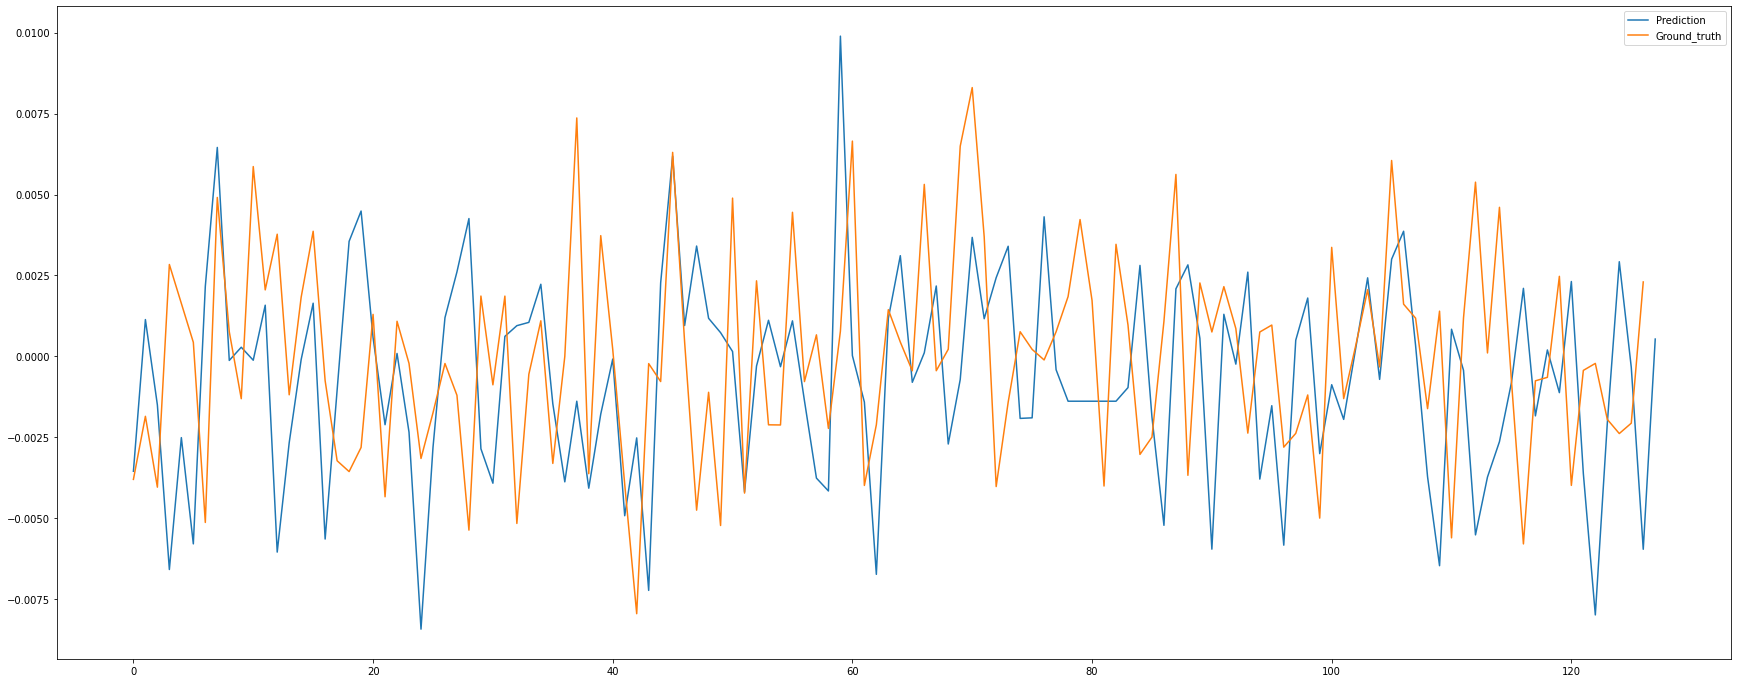

In [132]:
result = pd.DataFrame(preds, columns = {'Prediction'})
result['Ground_truth'] = raw_data.loc['2021'][44::].reset_index(drop = True)
result.plot(figsize = (30,12))

In [117]:
raw_data.loc['2021'][44::]

Date
2021-03-09   -0.003799
2021-03-10   -0.001850
2021-03-11   -0.004039
2021-03-12    0.002840
2021-03-15    0.001635
                ...   
2021-08-31   -0.000216
2021-09-01   -0.001945
2021-09-02   -0.002382
2021-09-03   -0.002062
2021-09-06    0.002301
Name: Close, Length: 127, dtype: float64

In [124]:
tmp_series = raw_data.loc['2021'][44::].reset_index(drop = True)
tmp_series

0     -0.003799
1     -0.001850
2     -0.004039
3      0.002840
4      0.001635
         ...   
122   -0.000216
123   -0.001945
124   -0.002382
125   -0.002062
126    0.002301
Name: Close, Length: 127, dtype: float64

<AxesSubplot:xlabel='Date'>

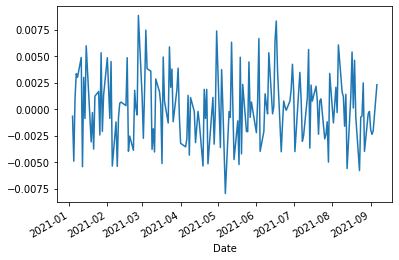

In [93]:
raw_data.loc['2021'].plot()

In [119]:
result

,Prediction,Ground_truth
0,-0.003548,True
1,0.001139,True
2,-0.001500,True
3,-0.006583,True
4,-0.002508,True
...,...,...
123,-0.002068,True
124,0.002926,True
125,-0.000334,True
126,-0.005957,True
